<a href="https://colab.research.google.com/github/sahilaf/Test_models/blob/main/Stress_strain_relation_using_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1️⃣ Load Your Experimental Data
# ==========================================

In [2]:
df = pd.read_csv("/content/soil_ML.csv")

## Plot data

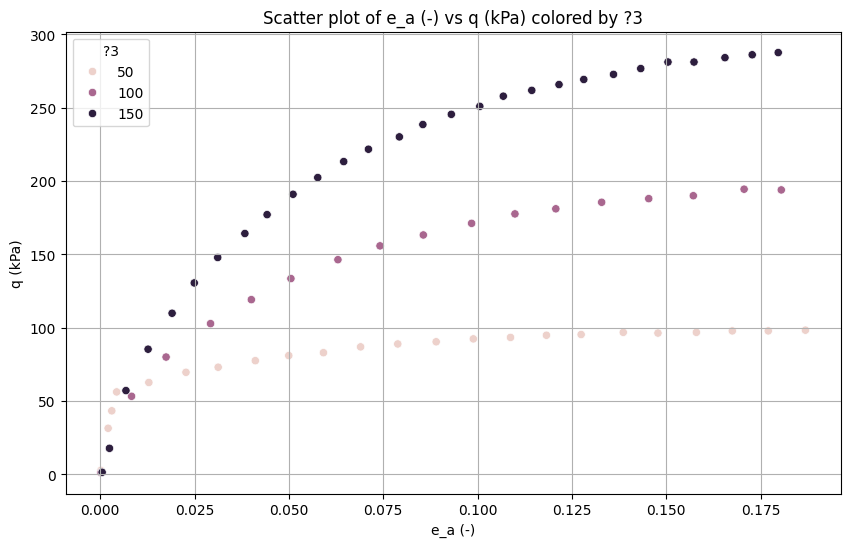

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='e_a (-)', y='q (kPa)', hue='?3')
plt.title('Scatter plot of e_a (-) vs q (kPa) colored by ?3')
plt.xlabel('e_a (-)')
plt.ylabel('q (kPa)')
plt.grid(True)
plt.show()

# Normalize the data

In [4]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, columns=df.columns)
df_scaled.head()

,e_a (-),q (kPa),?3
0,0.000000,0.005190,0.0
1,0.010301,0.105536,0.0
2,0.015473,0.147059,0.0
3,0.022396,0.192042,0.0
4,0.068072,0.214533,0.0


Rename the data frame

In [5]:
df = df.rename(columns={'e_a (-)': 'epsilon_a', 'q (kPa)': 'q', '?3': 'sigma_3'})
df_scaled = df_scaled.rename(columns={'e_a (-)': 'epsilon_a', 'q (kPa)': 'q', '?3': 'sigma_3'})
display(df.head())

,epsilon_a,q,sigma_3
0,0.000158,2.765087,50
1,0.002082,31.496411,50
2,0.003047,43.385235,50
3,0.004340,56.264794,50
4,0.012868,62.704574,50


In [6]:
# Extract normalized inputs and outputs
X_norm = df_scaled[['epsilon_a', 'sigma_3']].values
y_norm = df_scaled[['q']].values

# Keep original min/max for denormalization later
q_min, q_max = df['q'].min(), df['q'].max()

# ==========================================
# 2️⃣ Build the Neural Network
# ==========================================

In [7]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(1, activation=None)
    ])
    return model

model = build_model()

# ==========================================
# 3️⃣ Define Physics-Informed Loss
# ==========================================
# Physics rule: dq/dε_a >= 0 and dq/dσ₃ >= 0 (monotonic increase)

In [8]:
@tf.function
def physics_loss(X):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        q_pred = model(X)
    dq_dX = tape.gradient(q_pred, X)
    dq_deps = dq_dX[:, 0:1]  # derivative wrt axial strain
    dq_dsig3 = dq_dX[:, 1:2] # derivative wrt confining pressure
    # Penalize negative derivatives (unphysical)
    penalty = tf.reduce_mean(tf.nn.relu(-dq_deps)) + tf.reduce_mean(tf.nn.relu(-dq_dsig3))
    return penalty

# ==========================================
# 4️⃣ Training Loop
# ==========================================

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(X, y):
    with tf.GradientTape() as tape:
        y_pred = model(X)
        data_loss = tf.reduce_mean(tf.square(y - y_pred))
        phys_loss = physics_loss(X)
        total_loss = data_loss + 0.01 * phys_loss
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, data_loss, phys_loss

epochs = 5000
for epoch in range(1, epochs + 1):
    total_loss, data_loss, phys_loss = train_step(
        tf.convert_to_tensor(X_norm, dtype=tf.float32),
        tf.convert_to_tensor(y_norm, dtype=tf.float32)
    )
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{epochs} | Total: {total_loss.numpy():.6f} | Data: {data_loss.numpy():.6f} | Phys: {phys_loss.numpy():.6f}")


Epoch 500/5000 | Total: 0.002662 | Data: 0.002521 | Phys: 0.014090
Epoch 1000/5000 | Total: 0.000700 | Data: 0.000679 | Phys: 0.002169
Epoch 1500/5000 | Total: 0.000442 | Data: 0.000413 | Phys: 0.002882
Epoch 2000/5000 | Total: 0.000379 | Data: 0.000338 | Phys: 0.004084
Epoch 2500/5000 | Total: 0.000332 | Data: 0.000287 | Phys: 0.004496
Epoch 3000/5000 | Total: 0.000294 | Data: 0.000252 | Phys: 0.004195
Epoch 3500/5000 | Total: 0.000264 | Data: 0.000225 | Phys: 0.003871
Epoch 4000/5000 | Total: 0.000240 | Data: 0.000209 | Phys: 0.003059
Epoch 4500/5000 | Total: 0.000256 | Data: 0.000235 | Phys: 0.002010
Epoch 5000/5000 | Total: 0.000199 | Data: 0.000180 | Phys: 0.001939


# ==========================================
# 5️⃣ Evaluate Results
# ==========================================
# Predict normalized q

In [10]:
y_pred_norm = model.predict(X_norm)

# Convert back to original kPa scale
y_pred = y_pred_norm * (q_max - q_min) + q_min
y_true = df['q'].values.reshape(-1, 1)

# Compute metrics
mae = np.mean(np.abs(y_pred - y_true))
rmae = (mae / np.mean(y_true)) * 100
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

print("\n====================== RESULTS ======================")
print(f"Mean Absolute Error (kPa): {mae:.3f}")
print(f"Relative MAE (RMAE): {rmae:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

====================== RESULTS ======================
Mean Absolute Error (kPa): 2.192
Relative MAE (RMAE): 1.50%
Root Mean Squared Error (RMSE): 3.836


# ==========================================
# 6️⃣ Visualization
# ==========================================

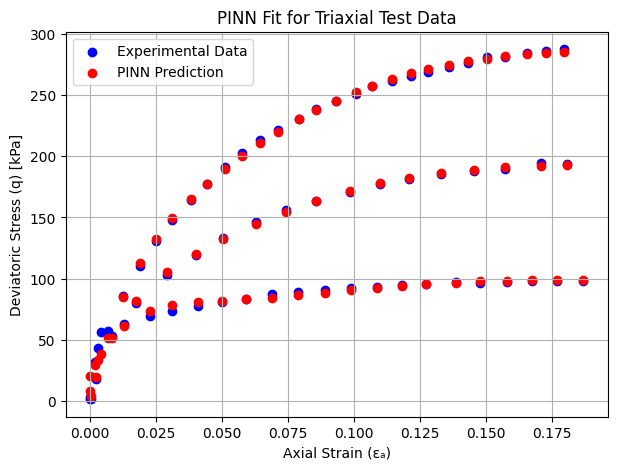

In [11]:
plt.figure(figsize=(7,5))
plt.scatter(df['epsilon_a'], df['q'], color='blue', label='Experimental Data')
plt.scatter(df['epsilon_a'], y_pred, color='red', label='PINN Prediction')
plt.xlabel("Axial Strain (εₐ)")
plt.ylabel("Deviatoric Stress (q) [kPa]")
plt.legend()
plt.title("PINN Fit for Triaxial Test Data")
plt.grid(True)
plt.show()